In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions as dist
from torchvision import datasets, transforms, utils
import numpy as np
import matplotlib.pyplot as plt

# Implementing classic VAE

We start by creating the VAE class 

In [2]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.latent_dim = latent_dim
        
        # Define the layers
        
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3_mean = nn.Linear(hidden_dim2, latent_dim)
        self.fc3_var = nn.Linear(hidden_dim2, latent_dim)
        
    def forward(self, x):
        out = F.elu(self.fc1(x))
        out = F.elu(self.fc2(out))
        mean = self.fc3_mean(out)
        var = self.fc3_var(out) # = diagonal elements of the covariance matrix (mean-field assumption on the latent variables so it can be expressed as a vector)
        
        return mean, var

In [3]:
class Decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.latent_dim = latent_dim
        
        # Define the layers
        
        self.fc1 = nn.Linear(latent_dim, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, input_dim)
        
    def forward(self, z):
        out = F.elu(self.fc1(z))
        out = F.elu(self.fc2(out))
        x = torch.sigmoid(self.fc3(out))
        
        return x

In [4]:
class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def reparameterization(self, mean, var):
        std = torch.exp(var) # To ensure we cannot have negative values in the variance
        sample = torch.randn_like(std)
        
        return mean + std * sample
    
    def loss(self, recon_x, x, mean, var):
        reconstruction_loss = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum') # We use cross entropy as pixels in binary MNIST follows a Bernoulli distribution 
        kl_divergence = - 0.5 * torch.sum(1 + var - mean.pow(2) - var.exp())

        return reconstruction_loss + kl_divergence
        
    def forward(self, x):
        mean, var = self.encoder(x)
        z = self.reparameterization(mean, var)
        recon_x = self.decoder(z)
        
        return recon_x, mean, var

We import MNIST and transform it into binary MNIST

In [5]:
batch_size = 100

# To transform MNIST into binary MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.where(x >= 0.5, torch.tensor(1, dtype=torch.float32), torch.tensor(0, dtype=torch.float32))),
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
n_class = len(train_dataset.classes) # Useful for the multi_encoder VAE
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size)

We train the VAE 

In [6]:
def train(vae_model, input_dim, loader, optimizer, n_epochs=20):
    """
    Train the VAE

    Params:
    - vae_model: An instance of VAE
    - input_dim: The dimension of the input
    - loader: The loader on which we will train the model
    - optimizer: The optimizer used to train
    - n_epochs: The number of training epochs
    """
    vae_model.train()

    for epoch in range(n_epochs):
        overall_loss = 0

        for batch_idx, (x, _) in enumerate(loader):
            x = x.view(batch_size, input_dim)
            
            optimizer.zero_grad()
            recon_x, mean, var = vae_model(x)
            loss = vae_model.loss(recon_x, x, mean, var)
            overall_loss += loss
            
            loss.backward()
            optimizer.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
        
    return overall_loss

In [20]:
train_classic_vae = False # Change to true if you want to train the VAE instead of taking the trained one

# Define the dimension of the layers
input_dim = 28 * 28
hidden_dim1 = hidden_dim2 = 200
latent_dim = 50

# Create the classic VAE
encoder = Encoder(input_dim, hidden_dim1, hidden_dim2, latent_dim)
decoder = Decoder(input_dim, hidden_dim1, hidden_dim2, latent_dim)
classic_vae = VAE(encoder, decoder)

# Training (if train == True) otherwise just load the already trained model
optimizer = torch.optim.Adam(list(classic_vae.encoder.parameters()) + list(classic_vae.decoder.parameters()), lr=0.001)

if train_classic_vae:
    train(classic_vae, input_dim, train_loader, optimizer)
    torch.save(classic_vae.state_dict(), 'save/classic_vae.pth')
else:
    classic_vae.load_state_dict(torch.load('save/classic_vae.pth'))

for param in classic_vae.encoder.parameters():
    param.requires_grad = False 
for param in classic_vae.decoder.parameters():
    param.requires_grad = False 

classic_vae.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'save/classic_vae.pth'

# Implementing WW

In [15]:
class Encoder_WW(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.latent_dim = latent_dim
        
        # Define the layers
        
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3_mean = nn.Linear(hidden_dim2, latent_dim)
        self.fc3_var = nn.Linear(hidden_dim2, latent_dim)
        
    def loss(self, z_samples, mean, var):
        normal_dist = dist.MultivariateNormal(mean, torch.diag_embed(torch.exp(var)))
        loss = normal_dist.log_prob(z_samples)
        n_samples = z_samples.size(0)
        
        return -torch.sum(loss)/n_samples
        
    def forward(self, x):
        out = F.elu(self.fc1(x))
        out = F.elu(self.fc2(out))
        mean = self.fc3_mean(out)
        var = self.fc3_var(out) # = diagonal elements of the covariance matrix (mean-field assumption on the latent variables so it can be expressed as a vector)
        
        return mean, var

In [16]:
class Decoder_WW(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, latent_dim):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.latent_dim = latent_dim
        
        # Define the layers
        
        self.fc1 = nn.Linear(latent_dim, hidden_dim2)
        self.fc2 = nn.Linear(hidden_dim2, hidden_dim1)
        self.fc3 = nn.Linear(hidden_dim1, input_dim)
        
    def loss(self,recon_x, x):
        loss = torch.empty_like(recon_x)

        x_expanded = x.repeat(recon_x.size(0),1,1)

        loss[x_expanded == 1] = torch.log(recon_x[x_expanded == 1])
        loss[x_expanded == 0] = torch.log(1 - recon_x[x_expanded == 0])
        
        n_samples = loss.size(0)
        loss = torch.sum(loss, dim=0)/n_samples

        return -torch.sum(loss)
        
    def forward(self, z):
        out = F.elu(self.fc1(z))
        out = F.elu(self.fc2(out))
        x = torch.sigmoid(self.fc3(out))
        
        return x

In [17]:
class WW(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def reparameterization(self, mean, var):
        std = torch.exp(var) # To ensure we cannot have negative values in the variance
        sample = torch.randn_like(std)
        
        return mean + std * sample
        
    def forward(self, x):
        mean, var = self.encoder(x)
        z = self.reparameterization(mean, var)
        recon_x = self.decoder(z)
        
        return recon_x, mean, var

In [18]:
def train_WW(vae_model, input_dim, loader, optimizer_encoder, optimizer_decoder, n_epochs=20, n_samples=10):
    """
    WW training

    Params:
    - vae_model: An instance of WW
    - input_dim: The dimension of the input
    - loader: The loader on which we will train the model
    - optimizer_encoder: The optimizer used to train the encoder
    - optimizer_decoder: The optimizer used to train the decoder
    - n_epochs: The number of training epochs
    """
    vae_model.train()

    for epoch in range(n_epochs):
        overall_loss = 0

        for batch_idx, (x, _) in enumerate(loader):
            x = x.view(batch_size, input_dim)
            
            # Decoder Wake phase
            optimizer_decoder.zero_grad()
            
            with torch.no_grad():
                mean, var = vae_model.encoder(x)

                samples = torch.unsqueeze(vae_model.reparameterization(mean, var),0)
                for _ in range(n_samples - 1):
                    samples = torch.cat((samples,torch.unsqueeze(vae_model.reparameterization(mean, var),0)), dim=0)
            
            recon_x = torch.unsqueeze(vae_model.decoder(samples[0]),0)

            for sample in samples[1:]:
                recon_x = torch.cat((recon_x, torch.unsqueeze(vae_model.decoder(samples[0]),0)), dim=0)
            
            loss = vae_model.decoder.loss(recon_x, x)
            overall_loss += loss
            
            loss.backward()
            optimizer_decoder.step()
            
            # Encoder wake phase
            optimizer_encoder.zero_grad()
            
            with torch.no_grad():
                z_samples = torch.randn(n_samples,vae_model.decoder.latent_dim)
                recon_x = vae_model.decoder(z_samples)
                uniform_random = torch.rand_like(recon_x)
                x_samples = torch.where(uniform_random > recon_x, torch.tensor(0.), torch.tensor(1.))

            mean, var = vae_model.encoder(x_samples)
            loss = vae_model.encoder.loss(z_samples, mean, var)
            overall_loss += loss
            
            loss.backward()
            optimizer_encoder.step()

        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size))
        
    return overall_loss

In [19]:
train_ww = True

# Define the dimension of the layers
input_dim = 28 * 28
hidden_dim1 = hidden_dim2 = 200
latent_dim = 50

# Create the WW
encoder_ww = Encoder_WW(input_dim, hidden_dim1, hidden_dim2, latent_dim)
decoder_ww = Decoder_WW(input_dim, hidden_dim1, hidden_dim2, latent_dim)
ww = WW(encoder_ww, decoder_ww)

# Training (if train == True) otherwise just load the already trained model
optimizer_encoder = torch.optim.Adam(ww.encoder.parameters(), lr=0.0001)
optimizer_decoder = torch.optim.Adam(ww.decoder.parameters(), lr=0.0001)

if train_ww:
    train_WW(ww, input_dim, train_loader, optimizer_encoder, optimizer_decoder)
    torch.save(ww.state_dict(), 'save/ww.pth')
else:
    ww.load_state_dict(torch.load('save/ww.pth'))

for param in ww.encoder.parameters():
    param.requires_grad = False 
for param in ww.decoder.parameters():
    param.requires_grad = False 

ww.eval()

	Epoch 1 	Average Loss:  tensor(282.7353, grad_fn=<DivBackward0>)
	Epoch 2 	Average Loss:  tensor(207.9039, grad_fn=<DivBackward0>)
	Epoch 3 	Average Loss:  tensor(202.7370, grad_fn=<DivBackward0>)
	Epoch 4 	Average Loss:  tensor(194.3177, grad_fn=<DivBackward0>)
	Epoch 5 	Average Loss:  tensor(192.0123, grad_fn=<DivBackward0>)
	Epoch 6 	Average Loss:  tensor(187.2543, grad_fn=<DivBackward0>)
	Epoch 7 	Average Loss:  tensor(178.1110, grad_fn=<DivBackward0>)
	Epoch 8 	Average Loss:  tensor(167.5507, grad_fn=<DivBackward0>)
	Epoch 9 	Average Loss:  tensor(159.8084, grad_fn=<DivBackward0>)
	Epoch 10 	Average Loss:  tensor(152.5081, grad_fn=<DivBackward0>)
	Epoch 11 	Average Loss:  tensor(146.0467, grad_fn=<DivBackward0>)
	Epoch 12 	Average Loss:  tensor(141.6624, grad_fn=<DivBackward0>)
	Epoch 13 	Average Loss:  tensor(138.1333, grad_fn=<DivBackward0>)
	Epoch 14 	Average Loss:  tensor(135.7734, grad_fn=<DivBackward0>)
	Epoch 15 	Average Loss:  tensor(133.9471, grad_fn=<DivBackward0>)
	Epo

WW(
  (encoder): Encoder_WW(
    (fc1): Linear(in_features=784, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
    (fc3_mean): Linear(in_features=200, out_features=50, bias=True)
    (fc3_var): Linear(in_features=200, out_features=50, bias=True)
  )
  (decoder): Decoder_WW(
    (fc1): Linear(in_features=50, out_features=200, bias=True)
    (fc2): Linear(in_features=200, out_features=200, bias=True)
    (fc3): Linear(in_features=200, out_features=784, bias=True)
  )
)

Original digit


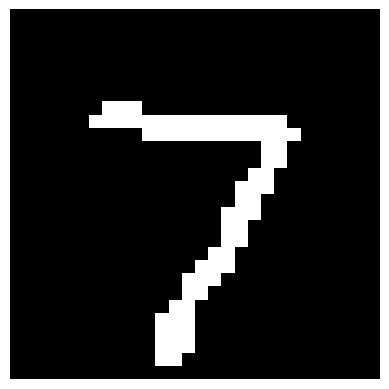

Reconstructed digit classic vae


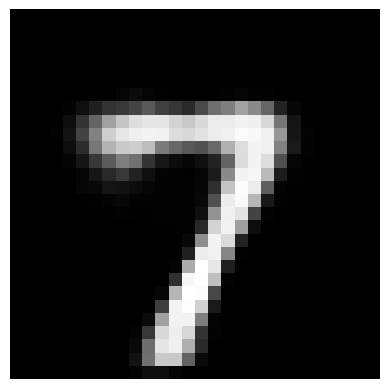

In [21]:
def show_digit(digit):
    # Digit must be a tensor of size 28x28
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

def generate_digit(decoder, sample):
    with torch.no_grad():
        gen_x = decoder(sample)
    digit = gen_x.reshape(28, 28) # reshape vector to 2d array
    
    return digit

x_batch, y_batch = next(iter(test_loader))
x = x_batch.view(batch_size, classic_vae.encoder.input_dim)[0]
y = y_batch[0]

print("Original digit")
show_digit(x.reshape(28,28))

with torch.no_grad():
    mean, var = ww.encoder(x)
recon_x = generate_digit(ww.decoder, ww.reparameterization(mean, var))
print("Reconstructed digit classic vae")
show_digit(recon_x)